In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, SimpleRNN
from tensorflow.keras.layers import Embedding, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

I am using the Covid twitter dataset with the goal of creating a sentiment classification model. The dataset contains around 3800 tweets related to Covid, each associated with a sentiment (Extremely Negative, Negative, Neutral, Positive, Extremely Positive).

The dataset can be accessed [here](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).

In [2]:
df_train = pd.read_csv('Data/Corona_NLP_train.csv', index_col=0, encoding='latin-1')
df_test = pd.read_csv('Data/Corona_NLP_test.csv', index_col=0, encoding='latin-1')
df_train.head()

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,,
3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


We don't really need any information other than the tweets and their associated sentiment, so lets drop all the other columns

In [3]:
df_train.drop(['ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df_test.drop(['ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 3799 to 44955
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 964.6+ KB


Next we just labeln encode the sentiment data to be represented in numerical form. For now I wont One-Hot encode the data as sentiment is an ordered class. Later on I will experiment with one-hot encoding for comparison.

In [4]:
labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
df_test['Sentiment_num'] = df_test['Sentiment'].apply(lambda x: labels.index(x))
df_train['Sentiment_num'] = df_train['Sentiment'].apply(lambda x: labels.index(x))
df_test[['Sentiment_num', 'Sentiment']]

,Sentiment_num,Sentiment
UserName,,
1,0,Extremely Negative
2,3,Positive
3,4,Extremely Positive
4,1,Negative
5,2,Neutral
...,...,...
3794,3,Positive
3795,1,Negative
3796,2,Neutral


Before we start with any model building, lets take a look at the class balance between the 5 sentiments. 

In [17]:
g = df_train.groupby(['Sentiment'])['Sentiment'].count()
g2 = df_test.groupby(['Sentiment'])['Sentiment'].count()
print(g+g2)

Sentiment
Extremely Negative     6073
Extremely Positive     7223
Negative              10958
Neutral                8332
Positive              12369
Name: Sentiment, dtype: int64


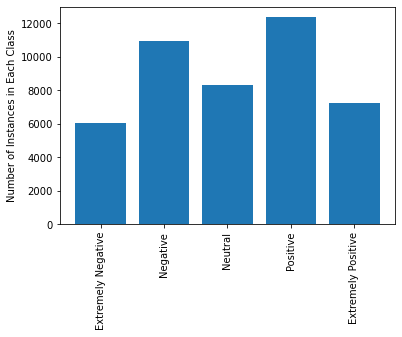

In [5]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 5

# print some stats of the data
unique, c_train = np.unique(df_train['Sentiment'], return_counts=True)
_, c_test = np.unique(df_test['Sentiment'], return_counts=True)
tot_counts = np.add(c_train, c_test) # Combine counts from both training and testing

idx = [0,2,3,4,1] # indexes so the instance counts are in order from extremely negative to extremely positive
plt.bar(list(range(NUM_CLASSES)),tot_counts[idx])
plt.xticks(list(range(NUM_CLASSES)), unique[idx], rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

They are not the most balanced classes in the world, with the Extremely negative and positive class differing by around 6000 instances. Both the Negative and Positive sentiments seem to be the most common, which is understandable as stronger emotions might be less common. Because of this imbalance, I will use k-folds in training to determine the best model, as k-folds works best with class imbalances.

Here I use the keras Tokenizer to extract all the words from all the tweets in the dataset.

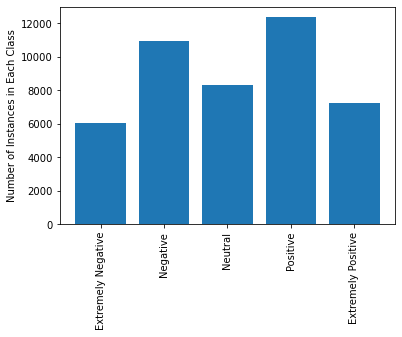

In [22]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 5

# print some stats of the data
df = pd.concat([df_test, df_train])
unique, counts = np.unique(df['Sentiment'], return_counts=True)

idx = [0,2,3,4,1] # indexes so the instance counts are in order from extremely negative to extremely positive
plt.bar(list(range(NUM_CLASSES)),counts[idx])
plt.xticks(list(range(NUM_CLASSES)), unique[idx], rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

In [24]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 300 # maximum number of words, max tweet length is 280 characters, added extra just in case

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df.OriginalTweet)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df.OriginalTweet)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y = df_train.Sentiment_num
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))

Found 90222 unique tokens. Distilled to 90222 top words.
Shape of data tensor: (44955, 300)
Shape of label tensor: (41157,)
90222
CPU times: user 2.77 s, sys: 52.8 ms, total: 2.82 s
Wall time: 2.83 s


The tweets overall contained aroun 85k total unique words. Thats a lot of unique words! But we have to keep in mind misspellings, abbreviations, slang, etc. which might not be tokenized correctly. 

I decided to use the GLoVe embeddings initially, as this will be easier and higher performing than making my own embeddings. Here I had to choose between two embeddings, one trained on Wikipedia, and another on a large Twitter corpus. 

In [25]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
# f = open('Data/glove.6B.100d.txt', encoding="utf8")
f = open('Data/glove/glove.twitter.27B.100d.txt', encoding="utf8")

# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 1193515 word vectors.
Embedding Shape: (90223, 100) 
 Total words found: 31404 
 Percentage: 34.80708910144863
CPU times: user 23.5 s, sys: 1 s, total: 24.5 s
Wall time: 24.8 s


35% is pretty low. However, given that we are using tweets, which do include lots of abbreviations and misspellings, it's not surprising. We will explore using different embedding strategies later on.

In [26]:
# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## LSTM Model

I will compare both the LSTM and the GRU architecture to get a sense of the how RNNs will perform against this dataset.

First, I have a function to create an LSTM model using our embedding layer, a single LSTM layer and a Dense layer. The reason for the function is to make it easier if I decide to do k-folds for training.

In [27]:
no_epochs=15

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def create_lstm_model(opt='rmsprop', neurons=20):
    rnn_lstm = Sequential() # A class for stacking layers, each layer has one input and one output tensor
    rnn_lstm.add(embedding_layer)
    rnn_lstm.add(LSTM(neurons,dropout=0.2, recurrent_dropout=0.2)) # LSTM layer. neurons: number of cells. dropout: input units dropped. recur drop: units dropped between cells
    rnn_lstm.add(Dense(NUM_CLASSES, activation
                       ='sigmoid')) # normal NN layer, a*W=z
    rnn_lstm.compile(loss='categorically_crossentropy',
                     optimizer=opt,
                     metrics=['accuracy']) # defines loss function, optimzers, and metrics to track
    return rnn_lstm

model = create_lstm_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          9022300   
                                                                 
 lstm (LSTM)                 (None, 20)                9680      
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                                 
Total params: 9,032,085
Trainable params: 9,785
Non-trainable params: 9,022,300
_________________________________________________________________
None


Here I defined a function for training the model.

In [17]:
def train_model(model, X_train, y_train, X_test, y_test,epochs=no_epochs):
    # history_lstm = []
    tmp = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                       epochs=epochs, 
                       batch_size=64) # number of samples per batch of computation
    # history_lstm.append( tmp )
    return tmp

One important concept that is not usually outlined is the real reason for using K-folds and cross validation during model creation. The reason to use K-folds cross validation over normal train-test split comes down to imbalance within the dataset. If the dataset is small or the classes are very imbalanced, then the chances of the testing set having an improportional and unfair distribution is a lot higher. In this case, we split the data into K amount of folds, where each fold is used as the testing split during each iteration. By doing this, we can evaluate the average performance of our particular model over the entire dataset, being confident that the results are not skewed because of datset imbalance. 

The reasoning for doing this is not for actually training a specific iteration of a model that we will then deploy, as I previously believed. The reason for this cross validation is for accurate comparisons between models, where we will be able to choose the best model architecture and hyperparameters for our task. After all this comparison is finished and our model is selected, we would then train it using ALL of our data, as we want to use all the data we have access too.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

sss = StatifiedShuffleSplit (n_splits=5, test_size = 0.2,
                             random_state=12345)

# store history for each fold to determie average performance later on
lstm_history = []
scores_lstm = []


for index, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print("Trianing on fold" + str(index+1) + "/5...")
    # Generating batches from the determined indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], X[test_idx]
    fold_history = []
    
    # Create model 
    model = None
    model = create_lstm_model(neurons=10)
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)
    
    # save model weights for future runs and history
    fold_history.append(tmp)
    lstm_history.append(fold_history)
    
    y_hat = model.predict(X_test)
    scores_lstm.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hat, axis=1)))

In [ ]:
plt.bar([1,2,3,4,5],scores_lstm)
plt.xticks([1,2,3],['1','2','3','4','5'])
plt.ylim(0.5,0.7)
plt.show()

To get the best overall evaluation from this model, let's combine the history from each LSTM model so we can print out the loss curve and accuracy curve. Its important to remember that the whole point of this process is not to create a deployable trained model, but rather to analyze and compare different model architectures so we can determine which approach is best to move on with for this specific task.